In [1]:
using QuantumOptics
using IonSim
import PyPlot

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

In [2]:
# Run this cell to test if the LinearChain object is gonna give us a headache.

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;


  7.743993 seconds (15.11 M allocations: 973.027 MiB, 4.47% gc time, 99.84% compilation time: <1% of which was recompilation)


$\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

$\textbf{TODO:}$ Work out how we get here from the IonSim master equation

We wish to scan over:
1. Intensity
2. Detuning
    
    a. Trapping frequency

    b. B-field (strength)

    c. Laser frequency

## 0. Setup

Global variables (we will add on to these)

In [3]:
CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ψ0_ELECTRONIC = CALCIUM40["S"] ⊗ CALCIUM40["S"] # |0> \otimes |0>
BELL_STATE = dm((CALCIUM40["S"] ⊗ CALCIUM40["S"] + 1im * CALCIUM40["D"] ⊗ CALCIUM40["D"])/√2); # (|00> + i|11>)/√2

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz

We also need initial values for:
- Trap frequency
- B-field strength
- Wavelength
- Intensity

In [4]:
TRAP_FREQUENCY_INITIAL = 2.5e5 # GLOBAL: intial trap frequency (Hz)
B_STRENGTH_INITIAL = 6e-4 # GLOBAL: initial magnetic field strength (T)

# Need a Chamber object to compute I_initial, λ_initial
ion1 = CALCIUM40
ion2 = CALCIUM40
chain = LinearChain(
        ions = [ion1, ion2], 
        comfrequencies = (x = 3e6, y = 3e6, z = TRAP_FREQUENCY_INITIAL), 
        selectedmodes = (;z = [1],)
)

laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser1.ϵ = x̂
laser1.k = ẑ
laser1.Δ = TRAP_FREQUENCY_INITIAL + DETUNING - AC_CORRECTION # blue sideband

laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
laser2.ϵ = x̂
laser2.k = ẑ
laser2.Δ = -(TRAP_FREQUENCY_INITIAL + DETUNING - AC_CORRECTION ) # red sideband

chamber = Chamber(iontrap=chain, B=B_STRENGTH_INITIAL, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);
WAVELENGTH_INITIAL = transitionwavelength(1, ("S", "D"), chamber) # GLOBAL: initial wavelength (m)
laser1.λ = WAVELENGTH_INITIAL
laser2.λ = WAVELENGTH_INITIAL

vibrational_mode = modes(chamber)[1]
η = abs(lambdicke(vibrational_mode, ion1, laser1))
pitime = η / DETUNING 
INTENSITY_INITIAL = intensity_from_pitime(1, pitime , 1, ("S", "D"), chamber) # GLOBAL: initial intensity (W/m^2)

# Clean up
ion1 = Nothing
ion2 = Nothing
chain = Nothing
laser1 = Nothing
laser2 = Nothing
chamber = Nothing
vibrational_mode = Nothing
η = Nothing
pitime = Nothing;


┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


Helper function for plotting

In [5]:
function plot_populations(chamber, tout, sol)
    vibrational_mode = modes(chamber)[1]

    SS = ionprojector(chamber, "S", "S")
    DD = ionprojector(chamber, "D", "D")
    SD = ionprojector(chamber, "S", "D")
    DS = ionprojector(chamber, "D", "S")
    bell_state_projector = dm((Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] 
        + 1im * Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"])/√2) ⊗ one(vibrational_mode)

    # compute expectation values
    prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
    prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
    prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
    prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
    prob_bell = expect(bell_state_projector, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

    # plot results
    fig  = plt.figure()
    plt.plot(tout, prob_SS, label="SS")
    plt.plot(tout, prob_DD, label="DD")
    plt.plot(tout, prob_SD, label="SD")
    plt.plot(tout, prob_DS, label="DS")
    plt.plot(tout, prob_bell, label="Bell state")
    plt.xlim(tout[1], tout[end])
    plt.ylim(0, 1)
    plt.legend(loc=1)
    plt.xlabel("Time (μs)");
    plt.display(fig)
end

plot_populations (generic function with 1 method)

## 1. Intensity scan

Scan over range of intensities, record fidelity and electronic-motional entanglement entropy

In [6]:
# Range of values over which to scan
I_range = 0:INTENSITY_INITIAL*1e-2:INTENSITY_INITIAL*1.5

# Intialize chamber object, whose properties will be updated in the loop
chamber = construct_MS_chamber(
    TRAP_FREQUENCY_INITIAL,
    INTENSITY_INITIAL,
    WAVELENGTH_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH_INITIAL
)
vibrational_mode = modes(chamber)[1] # first vibrational mode
ψ0_MOTIONAL = vibrational_mode[0] # GLOBAL: ground state of the first vibrational mode
ψ0 = ψ0_ELECTRONIC ⊗ ψ0_MOTIONAL # GLOBAL: initial state for all the simulations

fidelities = zeros(length(I_range))
entanglement_entropies = zeros(length(I_range))
idx = Int(0)
for I in I_range
    idx += 1

    intensity!(chamber.lasers[1], I)
    intensity!(chamber.lasers[2], I)

    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
    ρ_final = dm(sol[end])
    ρ_final_electronic = ptrace(ρ_final, 3)
    fid_i = fidelity(ρ_final_electronic, BELL_STATE)
    S_i = entropy_vn(ρ_final_electronic)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

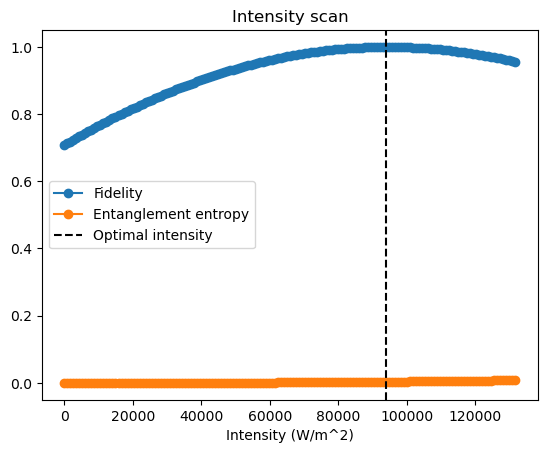

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Calibrated intensity = 93975.34935500399 W/m^2 

Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [7]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
INTENSITY_OPTIMAL = I_range[max_fidel_idx[1]] # GLOBAL: optimal intensity (W/m^2)

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Calibrated intensity = ", INTENSITY_OPTIMAL, " W/m^2 \n")

print("\nMax fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(I_range, fidelities, "o-", label = "Fidelity")
plt.plot(I_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=INTENSITY_OPTIMAL, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Intensity (W/m^2)")
plt.title("Intensity scan")
plt.legend()
plt.display(fig)
plt.close()

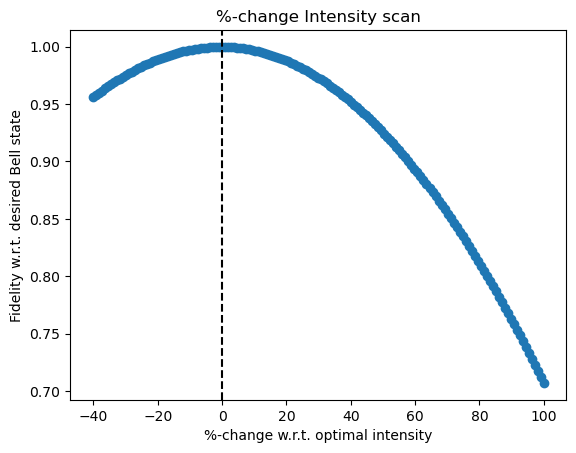

In [8]:
percent_change_intensity = 100 .*(INTENSITY_OPTIMAL .- I_range)/INTENSITY_OPTIMAL

fig = plt.figure()
plt.plot(percent_change_intensity, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("%-change w.r.t. optimal intensity")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("%-change Intensity scan")
plt.display(fig)

## 3. Trap-frequency scan

TODO: Include diagram from Sara meeting

Trap-frequency fluctuation $\Longleftrightarrow$ all reds spread (positive change) or squeeze (negative change)

In [9]:
ν_target = 2.5e5
ν_range = ν_target*1e-1:ν_target*1e-2:ν_target*2

fidelities = zeros(length(ν_range))
entanglement_entropies = zeros(length(ν_range))
idx = Int(0)
for ν_actual in ν_range
    idx += 1

    # We can't update the chamber's trap-frequency in place; need to reconstruct it
    chamber = construct_MS_chamber(
        ν_actual,
        INTENSITY_OPTIMAL,
        WAVELENGTH_INITIAL,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )

    # The construct_MS_chamber() function automatically sets the detuning based on the trap-frequency. 
    # But here we want to see what happens if the trap-frequency fluctuates and we *don't* know about it. 
    # So below, we set the detuning based on the *target* trap-frequency, not the actual trap-frequency.
    chamber.lasers[1].Δ = ν_target + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(ν_target + DETUNING - AC_CORRECTION)

    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
    ρ_final = dm(sol[end])
    ρ_final_electronic = ptrace(ρ_final, 3)
    fid_i = fidelity(ρ_final_electronic, BELL_STATE)
    S_i = entropy_vn(ρ_final_electronic)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end


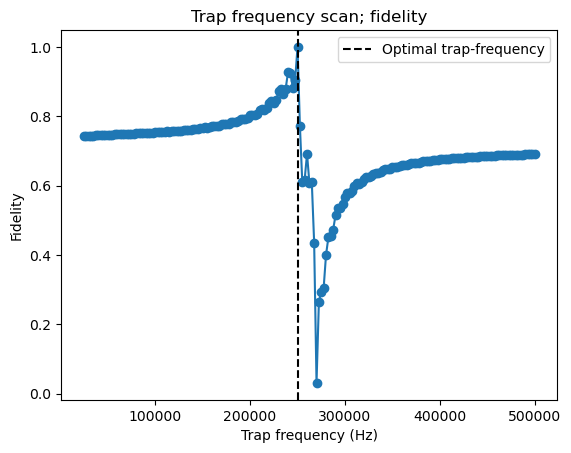

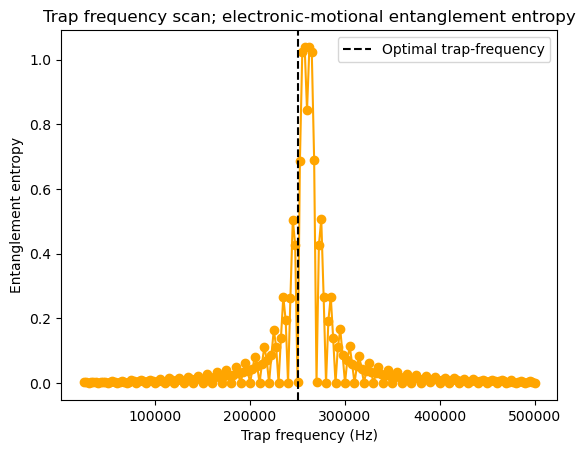

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 
Calibrated trap-frequency = 250000.0 Hz 

Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [11]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
TRAP_FREQUENCY_OPTIMAL = ν_range[max_fidel_idx[1]] # GLOBAL: optimal trap frequency (Hz)

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY_OPTIMAL, " W/m^2 \n")
print("Calibrated trap-frequency = ", TRAP_FREQUENCY_OPTIMAL, " Hz \n")

print("\nMax fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(ν_range, fidelities, "o-")
plt.axvline(x=TRAP_FREQUENCY_OPTIMAL, color="black", linestyle="--", label="Optimal trap-frequency")
plt.ylabel("Fidelity")
plt.xlabel("Trap frequency (Hz)")
plt.title("Trap frequency scan; fidelity")
plt.legend()
plt.display(fig)
plt.close()

fig = plt.figure()
plt.plot(ν_range, entanglement_entropies, "o-", c="orange")
plt.axvline(x=TRAP_FREQUENCY_OPTIMAL, color="black", linestyle="--", label="Optimal trap-frequency")
plt.ylabel("Entanglement entropy")
plt.xlabel("Trap frequency (Hz)")
plt.title("Trap frequency scan; electronic-motional entanglement entropy")
plt.legend()
plt.display(fig)
plt.close()


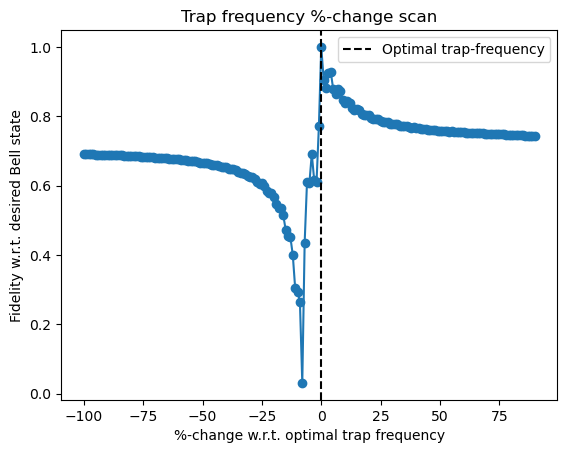

In [12]:
percent_change_tf = 100 .*(TRAP_FREQUENCY_OPTIMAL .- ν_range)/TRAP_FREQUENCY_OPTIMAL

fig = plt.figure()
plt.plot(percent_change_tf, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--", label="Optimal trap-frequency")
plt.xlabel("%-change w.r.t. optimal trap frequency")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("Trap frequency %-change scan")
plt.legend()
plt.display(fig)

## 4. Laser-wavelength scan

Laser frequency fluctuation $\Longleftrightarrow$ all greens shift (same direction, same amount)

### 4.a. Determining reasonably-computable orders-of-magnitude for fluctuations in the laser wavelength

Computing the Hamiltonian for a given laser frequency shift to arbitray order is computationally intractable, so we have to choose:
1. An RWA cutoff
    a. We choose $\texttt{FINITE\_RWA\_CUTOFF = 1e20}$ somewhat arbitrarily
2. An absolute maximum fluctuation in the laser wavelength. We find $\delta \lambda\_\texttt{MAX}$ empirically (see cell $\texttt{4.a.i}$ below). 

Interestingly enough, we don't get the same result when varying the laser-detuning $\texttt{laser.}\Delta$ vs. the laser-wavelength $\texttt{laser.}\lambda$, i.e. choosing $\delta \lambda = c/\delta f$ or vice-versa (compare cells $\texttt{4.a.i}$ and $\texttt{4.a.ii}$ below). They're certainly different parameters in the IonSim master equation, but varying either one should correspond to the same (or at least similar) physical behavior (if my understanding of the $\texttt{laser.}\lambda$ and $\texttt{laser.}\Delta$ parameters is correct)

$\textbf{TODO:}$ Figure out why this is.

4.a.i. Varying wavelength $\texttt{laser.}\lambda$

In [13]:
FINITE_RWA_CUTOFF = 1e20
λ_target = WAVELENGTH_INITIAL
δλ_MAX = 1e-15;

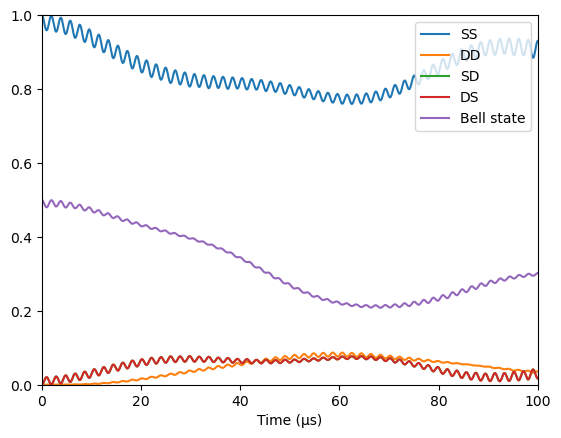

Bell-state fidelity: 0.5499414657427376
Electronic-Motional entanglement entropy: 0.1543687021453811


/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [14]:
#################### Initialize chamber ####################

chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        λ_target,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )

#################### Vary parameter of interest: 4 methods ####################

# 1. Setting δλ directly
δλ = -1e-17 # \pm 1e-15 is the LARGEST order-of-magnitude that terminates reasonably and doesn't give a trivial result (i.e. just straight horizontal lines)
wavelength!(chamber.lasers[1], λ_target + δλ)
wavelength!(chamber.lasers[2], λ_target + δλ)

# # 2. Setting δλ as a fraction of λ_target
# δλ = λ_target*1e-9 # \pm λ_target*1e-9 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result
# wavelength!(laser1, λ_target - δλ)
# wavelength!(laser2, λ_target - δλ)

# # 3. Setting δf as a fraction of f_target, then δλ = c0/δf
# c0 = 2.99792458e8
# f_target = c0/λ_target
# δf = f_target*1e9 # 1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
# δλ = -c0/δf
# wavelength!(laser1, λ_target + δλ)
# wavelength!(laser2, λ_target + δλ)

# # 4. No fluctuation
# wavelength!(laser1, λ_target)
# wavelength!(laser2, λ_target)

#################### Simulate, evaluate ####################

h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF);
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations(chamber, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")


4.a.ii. Varying detuning $\texttt{laser.}\Delta$

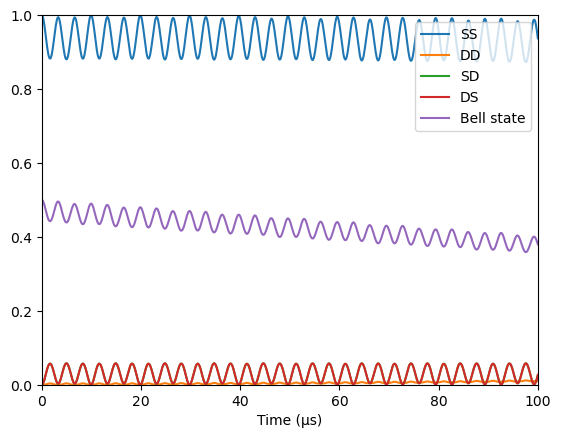

Bell-state fidelity: 0.6166353354899833
Electronic-Motional entanglement entropy: 0.004005969531643849


In [16]:
#################### Initialize chamber ####################

chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        λ_target,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )

#################### Vary parameter of interest: 4 methods ####################

# # 1. Setting δf directly
# δf = 1e5 # \pm 1e5 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result. Corresponds to δλ=c0/δf \sim 3e3  
# d = 0
# Δ_blue = TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf 
# Δ_red = -(TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf)

# # 2. Setting δf as a fraction of f_target
# c0 = 2.99792458e8
# f_target = c0/λ_target
# δf = -f_target*1e-9 # 1e-9 is the LARGEST oom that terminates reasonably and doesn't give a trivial result
# d = 0
# Δ_blue = TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf 
# Δ_red = -(TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf)

# 3. Setting δλ as a fraction of λ_target, then δf = c0/δλ
c0 = 2.99792458e8
δλ = λ_target*1e9 # \pm λ_target*1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
δf = -c0/δλ
d = 0
Δ_blue = TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf 
Δ_red = -(TRAP_FREQUENCY_OPTIMAL + DETUNING - d + δf)

# # 4. No fluctuation
# d = 0
# Δ_blue = TRAP_FREQUENCY_OPTIMAL + DETUNING - d 
# Δ_red = -(TRAP_FREQUENCY_OPTIMAL + DETUNING - d )

chamber.lasers[1].Δ = Δ_blue # blue sideband
chamber.lasers[2].Δ = Δ_red; # red sideband

#################### Simulate, evaluate ####################

h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF);
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations(chamber, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

## 4.b Running laser-wavelength scan

In [17]:
δλ_MAX = 1e-15
δλ_power_range = -25:0.1:-15
δλ_range = 10 .^ δλ_power_range
λ_plus_range = WAVELENGTH_INITIAL .+ δλ_range
λ_minus_range = WAVELENGTH_INITIAL .- δλ_range
λ_range = vcat(λ_minus_range, λ_plus_range)

chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        WAVELENGTH_INITIAL,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )

fidelities = zeros(length(λ_range))
entanglement_entropies = zeros(length(λ_range))
idx = Int(0)
for λ_actual in λ_range
    idx += 1

    wavelength!(chamber.lasers[1], λ_actual)
    wavelength!(chamber.lasers[2], λ_actual)

    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
    
    ρ_final = dm(sol[end])
    ρ_final_electronic = ptrace(ρ_final, 3)
    fid_i = fidelity(ρ_final_electronic, BELL_STATE)
    S_i = entropy_vn(ρ_final_electronic)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

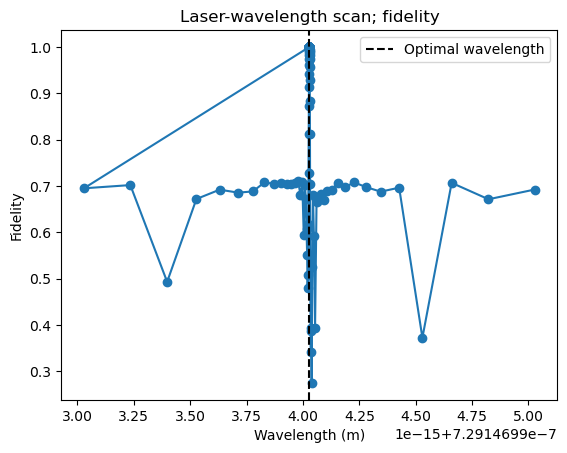

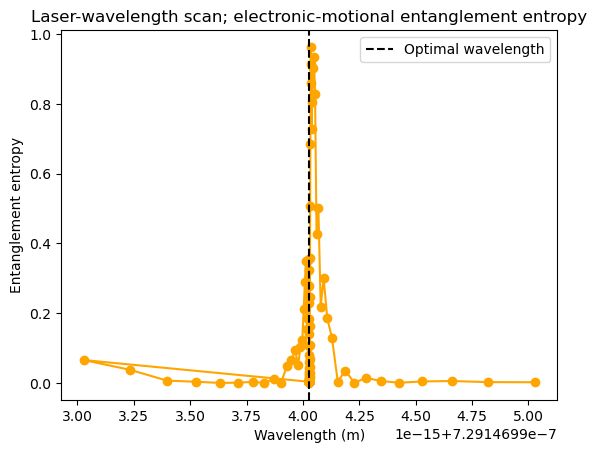

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 
Calibrated wavelength= 7.291469940286511e-7 m 

Max fidelity = 0.9998161509453058
Entanglement entropy at max fidelity = 0.002903568196670668


In [18]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
WAVELENGTH_OPTIMAL = λ_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("\nIntensity = ", INTENSITY_OPTIMAL, " W/m^2 \n")
print("Trapping frequency = ", TRAP_FREQUENCY_OPTIMAL, " Hz \n")
print("Calibrated wavelength= ", WAVELENGTH_OPTIMAL, " m \n"
)
print("\nMax fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(λ_range, fidelities, "o-")
plt.axvline(x=WAVELENGTH_OPTIMAL, color="black", linestyle="--", label="Optimal wavelength")
plt.ylabel("Fidelity")
plt.xlabel("Wavelength (m)")
plt.title("Laser-wavelength scan; fidelity")
plt.legend()
plt.display(fig)
plt.close()

fig = plt.figure()
plt.plot(λ_range, entanglement_entropies, "o-", c="orange")
plt.axvline(x=WAVELENGTH_OPTIMAL, color="black", linestyle="--", label="Optimal wavelength")
plt.ylabel("Entanglement entropy")
plt.xlabel("Wavelength (m)")
plt.title("Laser-wavelength scan; electronic-motional entanglement entropy")
plt.legend()
plt.display(fig)
plt.close()

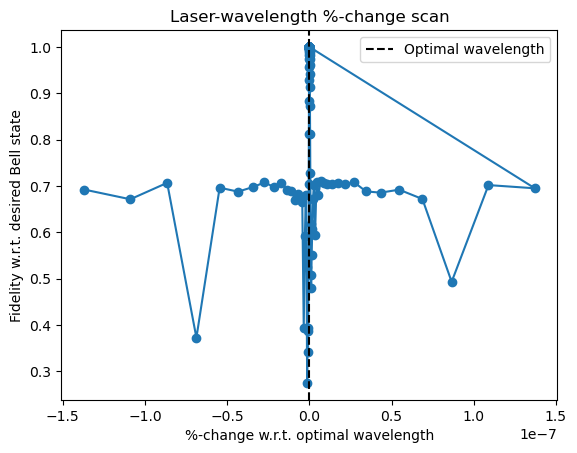

In [19]:
percent_change_λ = 100 .*(WAVELENGTH_OPTIMAL .- λ_range)/WAVELENGTH_OPTIMAL

fig = plt.figure()
plt.plot(percent_change_λ, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--", label = "Optimal wavelength")
plt.xlabel("%-change w.r.t. optimal wavelength")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("Laser-wavelength %-change scan")
plt.legend()
plt.display(fig)
plt.close()

## 5. Finally, scan the magnetic field strength

### 5.a. Computability scan

Again, we must first determine the computationally practical domain for our chosen finite RWA cutoff (1e20).

$\textbf{TODO}$: Again, setting $\texttt{chamber.B = B + } \delta \texttt{B}$ gives similar, but not exactly the same, result as setting $\texttt{chamber.}\delta\texttt{B = }\delta\texttt{B}$.

In the future: fast fluctuations and polarization direction?

In [20]:
FINITE_RWA_CUTOFF = 1e20
B_target = B_STRENGTH_INITIAL
δB_MAX = 1e-4;

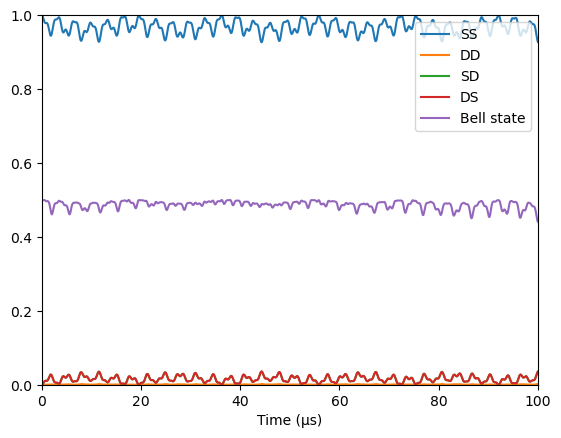

Bell-state fidelity: 0.6642217222355218
Electronic-Motional entanglement entropy: 0.0986034995464703


0.0001

In [21]:
δB = -1e-4

chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        WAVELENGTH_OPTIMAL,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )    
chamber.B = chamber.B + δB

#################### Chamber-dependent laser properties ####################

h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF);
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations(chamber, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

δB_MAX = 1e-4

In [22]:
δB_power_range = -10:0.1:-4
δB_range = 10 .^ δB_power_range
B_plus_range = B_target .+ δB_range
B_minus_range = B_target .- δB_range
B_range = vcat(B_minus_range, B_plus_range)
δB_range = B_target .- B_range

chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        WAVELENGTH_OPTIMAL,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_INITIAL
    )  
fidelities = zeros(length(B_range))
entanglement_entropies = zeros(length(B_range))
idx = Int(0)
for B_actual in B_range
    idx += 1

    #################### Chamber ####################
    chamber.B = B_actual
    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);

    ρ_final = dm(sol[end])
    ρ_final_electronic = ptrace(ρ_final, 3)
    fid_i = fidelity(ρ_final_electronic, BELL_STATE)
    S_i = entropy_vn(ρ_final_electronic)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

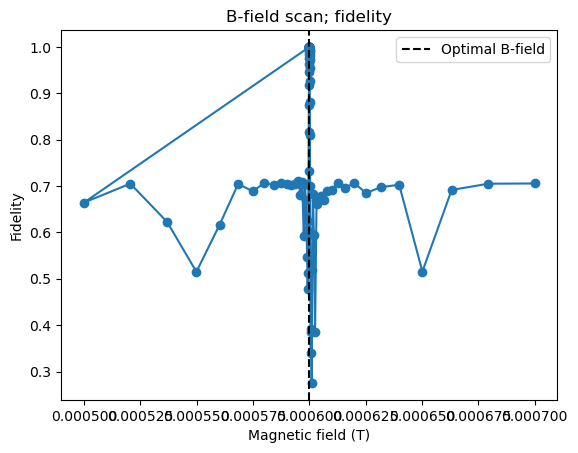

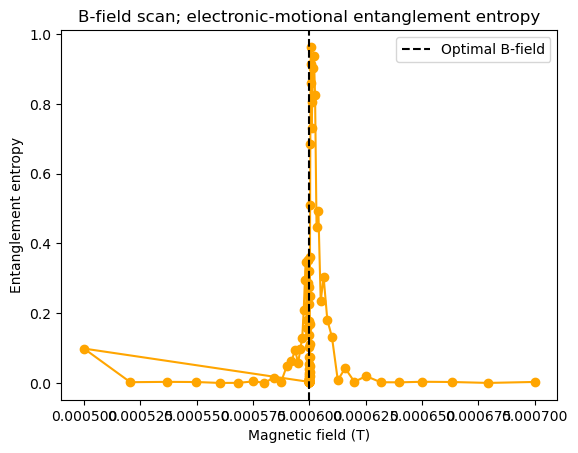

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 
Laser (carrier) wavelength= 7.291469940286511e-7 m 
Calibrated magnetic field= 0.0005999998999999999 T 

Max fidelity = 0.9998161808711384
Entanglement entropy at max fidelity = 0.0029198516661979408


In [23]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
δB_optimal = δB_range[max_fidel_idx[1]]
B_STRENGTH_OPTIMAL = B_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY_OPTIMAL, " W/m^2 \n")
print("Trapping frequency = ", TRAP_FREQUENCY_OPTIMAL, " Hz \n")
print("Laser (carrier) wavelength= ", WAVELENGTH_OPTIMAL, " m \n")
print("Calibrated magnetic field= ", B_STRENGTH_OPTIMAL, " T \n")

print("\nMax fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(B_range, fidelities, "o-")
plt.axvline(x=B_STRENGTH_OPTIMAL, color="black", linestyle="--", label="Optimal B-field")
plt.ylabel("Fidelity")
plt.xlabel("Magnetic field (T)")
plt.title("B-field scan; fidelity")
plt.legend()
plt.display(fig)
plt.close()

fig = plt.figure()
plt.plot(B_range, entanglement_entropies, "o-", c="orange")
plt.axvline(x=B_STRENGTH_OPTIMAL, color="black", linestyle="--", label="Optimal B-field")
plt.ylabel("Entanglement entropy")
plt.xlabel("Magnetic field (T)")
plt.title("B-field scan; electronic-motional entanglement entropy")
plt.legend()
plt.display(fig)
plt.close()

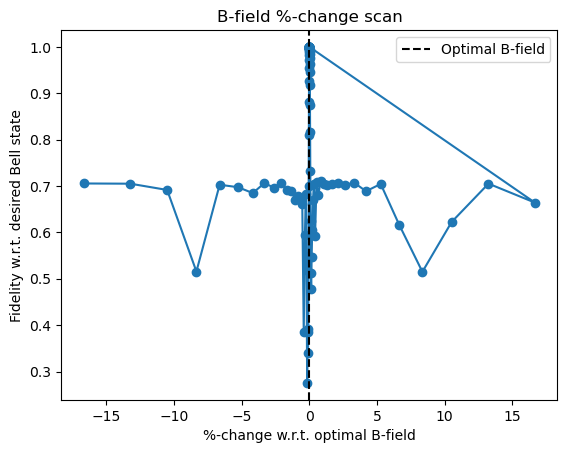

In [24]:
percent_change_B = 100 .*(B_STRENGTH_OPTIMAL .- B_range)/B_STRENGTH_OPTIMAL

fig = plt.figure()
plt.plot(percent_change_B, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--", label = "Optimal B-field")
plt.xlabel("%-change w.r.t. optimal B-field")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("B-field %-change scan")
plt.legend()
plt.display(fig)
plt.close()

## 6. Get final fidelity

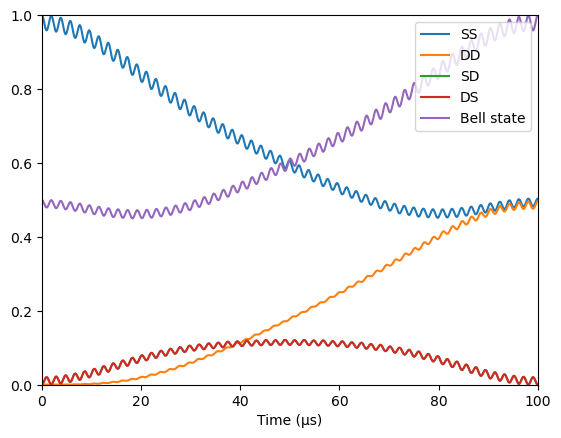

  0.105233 seconds (1.76 M allocations: 67.441 MiB)
Bell-state fidelity: 0.9998161808711384
Electronic-Motional entanglement entropy: 0.0029198516661979408


In [26]:
chamber = construct_MS_chamber(
        TRAP_FREQUENCY_OPTIMAL,
        INTENSITY_OPTIMAL,
        WAVELENGTH_OPTIMAL,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH_OPTIMAL
    )  

h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF);
@time tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations(chamber, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")